In [145]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torchsummary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms.functional import resize, to_tensor, to_pil_image
from PIL import Image
from tqdm import tqdm
import os, datetime ,json


In [146]:
def pil_from_minus1to1(t):
    """
    Convertit un tenseur [-1,1] (CHW ou 1,C,H,W) en PIL Image.
    """
    t = t.squeeze(0) if t.dim() == 4 else t          # B×C×H×W → C×H×W
    t = ((t.clamp(-1, 1) + 1) / 2)                   # [-1,1] → [0,1]
    return to_pil_image(t.cpu())

In [147]:
def extract_patches(img, patch_size, stride):
    
    img_batch = img.unsqueeze(0)  # (1, C, H, W)
    patches = torch.nn.functional.unfold(img_batch, kernel_size=patch_size, stride=stride)
    patches = patches.squeeze(0).T  # (num_patches, C*patch_size*patch_size)
   
    return patches

def get_gaussian_params(patches, debug=True):
    # patches: Tensor (N, D)
    
    mu = patches.mean(dim=0)
    centered = patches - mu
    Sigma = (centered.T @ centered) / (patches.shape[0] - 1)
    
    return mu, Sigma

import torch

def matrix_sqrt_eig(mat, eps=1e-10, debug=True):
    """
    Symmetric square root of an SPD matrix via eigen-decomposition.
    """
    # 1) Enforce perfect symmetry
    mat = (mat + mat.T) / 2

    # 2) Eigen-decomposition
    vals, vecs = torch.linalg.eigh(mat)
    # 3) Clamp to avoid tiny negatives, then sqrt
    vals = torch.clamp(vals, min=eps)
    sqrt_mat = vecs @ torch.diag(torch.sqrt(vals)) @ vecs.T

    # 4) Re-symmetrize result
    sqrt_mat = (sqrt_mat + sqrt_mat.T) / 2
    

    return sqrt_mat

def wasserstein_2_gaussian_eig(mu1, Sigma1, mu2, Sigma2, eps=1e-12, debug=True):
    """
    Computes W2^2 between two Gaussians (mu1, Sigma1) and (mu2, Sigma2),
    using a robust eigen-based sqrt.
    """
    # Mean term
    diff_mu_sq = torch.norm(mu1 - mu2)**2
    if debug:
        print("moyenne diff =", diff_mu_sq.item())

    # double sinon pas assez précis. 
    A = Sigma1 + eps * torch.eye(Sigma1.size(0), device=Sigma1.device,dtype=torch.float64)
    S1 = matrix_sqrt_eig(A, eps=eps, debug=debug)

    # Inner product √(S1 Σ2 S1)
    prod = S1 @ Sigma2 @ S1
    S2 = matrix_sqrt_eig(prod, eps=eps, debug=debug)

    # Trace term
    trace_term = torch.trace(Sigma1 + Sigma2 - 2 * S2)
    if debug:
        print("trace term =", trace_term.item())

    return diff_mu_sq + trace_term


In [148]:
class Generator(nn.Module):
    
    def __init__(self,n_hidden):
        super().__init__()
        self.n_hidden = n_hidden
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.n_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            # Last conv layer outputs 3 channels (RGB), no batchnorm or activation
            nn.Conv2d(self.n_hidden, 3, 3, padding=1),
            nn.Tanh()
        )
        
    def forward(self,input):
        return self.main(input)

In [149]:
im_name_to_path = {
    "oiseau" : "images/birds.png"
}

In [150]:

# --- (1) nom du modèle à charger -----------------------------------------------------
image_name = "oiseau"
model_name = "basic"
model_dir  = os.path.join("models",image_name ,model_name)
weights_fp = os.path.join(model_dir, "generators.pt")
descr_fp   = os.path.join(model_dir, "Description.txt")
sigma_fp   = os.path.join(model_dir, "sigma_n.json")
zstar_fp   = os.path.join(model_dir, "z_star.pt")  

if not os.path.exists(weights_fp):
    raise FileNotFoundError(f"Impossible de trouver le fichier : {weights_fp}")

# --- (2) on lit la liste de state_dict ----------------------------------------------
state_list = torch.load(weights_fp, map_location="cpu")
print(f"{len(state_list)} générateurs trouvés dans le checkpoint")

# (facultatif) on affiche le petit fichier description
if os.path.isfile(descr_fp):
    print("─── Description.txt ───")
    with open(descr_fp, encoding="utf-8") as f:
        print(f.read().strip())
    print("────────────────────────\n")

# --- (2bis) on charge la liste sigma_n ----------------------------------------------
if os.path.isfile(sigma_fp):
    with open(sigma_fp, "r", encoding="utf-8") as f:
        loaded_sigma_n = json.load(f)
    print(f"sigma_n chargé ({len(loaded_sigma_n)} éléments) → 'loaded_sigma_n'")
else:
    raise FileNotFoundError(f"Impossible de trouver le fichier sigma_n : {sigma_fp}")

# --- (2ter) on charge z_star -------------------------------------------------------
if os.path.isfile(zstar_fp):
    loaded_z_star = torch.load(zstar_fp, map_location="cpu")
    print(f"z_star chargé de taille {tuple(loaded_z_star.shape)} → 'loaded_z_star'")
else:
    raise FileNotFoundError(f"Impossible de trouver le fichier z_star : {zstar_fp}")

# --- (3) fonction helper : recrée un Generator adapté au state_dict -----------------
def build_generator_from_state(sd, device="cpu"):
    for key in sd.keys():
        if key.endswith(".weight") and sd[key].dim() == 4:
            n_hidden = sd[key].shape[0]
            break
    else:
        raise KeyError("Impossible d'inférer n_hidden depuis le state_dict.")
    G = Generator(n_hidden).to(device)
    G.load_state_dict(sd, strict=True)
    G.eval()
    for p in G.parameters():
        p.requires_grad_(False)
    return G

# --- (4) on construit la liste des générateurs chargés ------------------------------
device = torch.device("cpu")
loaded_generators = [build_generator_from_state(sd, device=device) for sd in state_list]

print(f"{len(loaded_generators)} générateurs instanciés → 'loaded_generators'")


8 générateurs trouvés dans le checkpoint
─── Description.txt ───
date: 2025-05-30T16:14:07
N: 8
lambda_gp: 10
r: 1.333
lr: 0.0005
betas: (0.5, 0.999)
n_Discriminator: 5
n_Generator: 2
iter_per_scale: 2000
alpha_rec: 10
beta_sigma: 0.1
comment: Sin Gan avec poids classique comme dans le papier sauf le padding
────────────────────────

sigma_n chargé (8 éléments) → 'loaded_sigma_n'
z_star chargé de taille (1, 3, 21, 32) → 'loaded_z_star'
8 générateurs instanciés → 'loaded_generators'


In [151]:
loaded_params = {}
with open(descr_fp, encoding="utf-8") as f:
    for line in f:
        if ": " not in line:
            continue
        key, val = line.strip().split(": ", 1)
        loaded_params[key] = val

# Conversion au bon type
loaded_N = int(loaded_params["N"])
loaded_r = float(loaded_params["r"])  

print(f"Hyperparams chargés → N={loaded_N}, r={loaded_r}")


Hyperparams chargés → N=8, r=1.333


In [152]:
loaded_params

{'date': '2025-05-30T16:14:07',
 'N': '8',
 'lambda_gp': '10',
 'r': '1.333',
 'lr': '0.0005',
 'betas': '(0.5, 0.999)',
 'n_Discriminator': '5',
 'n_Generator': '2',
 'iter_per_scale': '2000',
 'alpha_rec': '10',
 'beta_sigma': '0.1',
 'comment': 'Sin Gan avec poids classique comme dans le papier sauf le padding'}

In [153]:
path = im_name_to_path[image_name]
im = Image.open(path).convert("RGB")
im_tensor_cpu = to_tensor(im).to(device="cpu")

print(f"inital tensor size : {im_tensor_cpu.shape}")


max_dim = 250
_, H, W = im_tensor_cpu.shape
scale_factor = max_dim / max(H, W)

new_H = int(H * scale_factor)
new_W = int(W * scale_factor)
im_resized = resize(im_tensor_cpu.unsqueeze(0), size=[new_H, new_W], antialias=True).squeeze(0) *2 -1

print(f"rescaled tensor size : {im_resized.shape}")

inital tensor size : torch.Size([3, 164, 244])
rescaled tensor size : torch.Size([3, 168, 249])


In [154]:
scales = [im_resized.unsqueeze(0)]    # niveau 0 = fine

for i in range(0, loaded_N):
    prev = scales[-1]
    _, _, h, w = prev.shape
    new_h = max(int(h / loaded_r), 1)
    new_w = max(int(w / loaded_r), 1)
    down = resize(prev, size=[new_h, new_w], antialias=True)
    scales.append(down)


In [155]:
@torch.no_grad()
def generate_multiscale(start_scale: int = loaded_N - 1,Generators = loaded_generators):
    """
    start_scale = 0  → on ne renouvelle le bruit qu’à la fine scale
    start_scale = N-1→ on renouvelle le bruit à toutes les échelles
    """
    # Génération totale
    if start_scale == loaded_N-1 : 
        h, w = scales[-1].shape[2:]
        gen_image = [torch.zeros((1, 3, h, w), device=device)]

         # 2. on remonte coarse → fine
        for i in range(loaded_N):
            k = loaded_N - 1 - i                    
        
            prev = gen_image[-1]
            if prev.shape[2:] != scales[k].shape[2:]:
                prev = F.interpolate(prev, size=scales[k].shape[2:],
                                    mode='bilinear', align_corners=False)

            z = torch.randn_like(prev) * loaded_sigma_n[k]
            

            x_k = Generators[k](z + prev) + prev
            gen_image.append(x_k)

        

    else : 
        low = scales[start_scale+1] 
        up = F.interpolate(low, size=scales[start_scale].shape[2:],
                                    mode='bilinear', align_corners=False)
        gen_image = [up]

         # 2. on remonte coarse → fine
        for scale in range(start_scale,-1,-1):
                            
            prev = gen_image[-1]
            if prev.shape[2:] != scales[scale].shape[2:]:
                prev = F.interpolate(prev, size=scales[scale].shape[2:],
                                    mode='bilinear', align_corners=False)

            z = torch.randn_like(prev) * loaded_sigma_n[scale]
            x_k = Generators[scale](z + prev) + prev
            gen_image.append(x_k)

    
    return gen_image[1:]
        
    


In [156]:
# Cell 2: Génération et stockage des échantillons
out_dir = "outputs/" + image_name
os.makedirs(out_dir, exist_ok=True)

K = 8
final_imgs = []
for k in range(K):
    imgs = generate_multiscale(start_scale=loaded_N-1, Generators=loaded_generators)
    # On stocke la dernière image de chaque synthèse
    final_imgs.append(imgs[-1].cpu().squeeze())

# Convertir en [0,1] et assembler en un seul tenseur
fake_tensor = torch.stack(final_imgs)               # (K, C, H, W)
fake_tensor01 = (fake_tensor.clamp(-1, 1) + 1) / 2   # [-1,1] → [0,1]
print("Fake tensor shape:", fake_tensor01.shape)


Fake tensor shape: torch.Size([8, 3, 168, 249])


In [157]:
# Cell 4: Extract patches from fake images & print

patch_size = 20
stride = 3

all_fake_patches = [extract_patches(img, patch_size, stride) for img in fake_tensor01]
patches_fake = torch.cat(all_fake_patches, dim=0).double()

print("Fake patches shape:", patches_fake.shape)  # (total_fake_patches, C*patch_size^2)


Fake patches shape: torch.Size([30800, 1200])


In [158]:
# Cell 5: Process real image & print shape

# Suppose im_resized is your real image Tensor of shape (C, H, W)
# If you have im_resized.unsqueeze(0), do:
real_tensor = scales[0]  # (1, C, H, W)
print("Real tensor shape:", real_tensor.shape)

real_img = real_tensor.squeeze(0)      # (C, H, W)
print("Real image shape after squeeze:", real_img.shape)

# Normalize real image to [0,1] just like your fakes
real_img01 = (im_resized.clamp(-1, 1) + 1) / 2    # (C, H, W)

patches_real = extract_patches(real_img01, patch_size, stride).double()
print("Real patches shape:", patches_real.shape)


Real tensor shape: torch.Size([1, 3, 168, 249])
Real image shape after squeeze: torch.Size([3, 168, 249])
Real patches shape: torch.Size([3850, 1200])


In [159]:
print("Real image stats:", real_img01.min().item(), real_img01.max().item(), real_img01.mean().item())
print("Fake image stats:", fake_tensor01.min().item(), fake_tensor01.max().item(), fake_tensor01.mean().item())


Real image stats: 0.0 1.0 0.5860886573791504
Fake image stats: 0.0 1.0 0.5919207334518433


In [160]:
# Cell 6: Compute Gaussian params & W2 distance

mu_fake, Sigma_fake = get_gaussian_params(patches_fake)
mu_real, Sigma_real = get_gaussian_params(patches_real)

w2 = wasserstein_2_gaussian_eig(mu_real, Sigma_real, mu_fake, Sigma_fake)
print(f"Wasserstein-2 Distance (squared): {w2.item():.4f}")


moyenne diff = 0.06053602609473767
trace term = 0.06035963067794908
Wasserstein-2 Distance (squared): 0.1209


### Show some patches

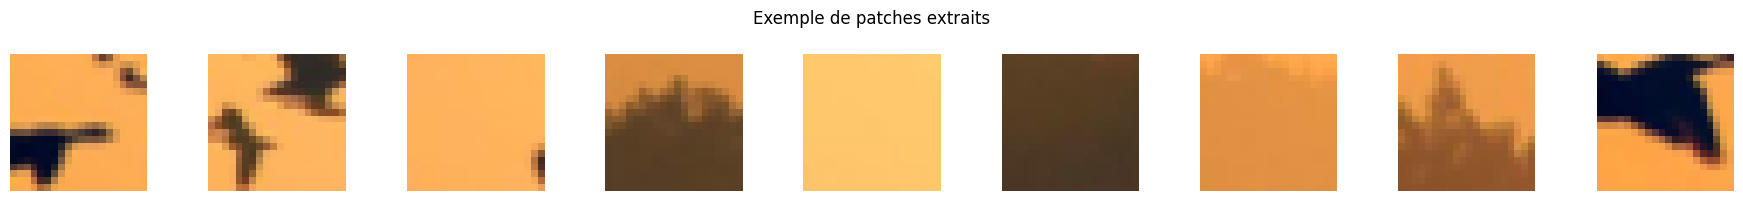

In [161]:
import random

# image 0-1 en entrée
patches = extract_patches(real_img01, patch_size, stride)  # (N, C*patch_size*patch_size)
N, D = patches.shape
C = real_img.shape[0]

# Sélection aléatoire de quelques patches
num_display = 9
indices = random.sample(range(N), num_display)

# Affichage
fig, axes = plt.subplots(1, num_display, figsize=(num_display * 2, 2))
for ax, idx in zip(axes, indices):
    vec = patches[idx]
    img_patch = vec.view(C, patch_size, patch_size).permute(1, 2, 0).cpu().numpy()
    # Si vos patches sont normalisés [0,1], on les affiche directement
    ax.imshow(img_patch)
    ax.axis('off')
    
plt.suptitle("Exemple de patches extraits", fontsize=12)
plt.tight_layout()
plt.show()

In [167]:
import numpy as np

patch_sizes   = [3, 7, 11,20,30]                 # Plusieurs tailles de patch
start_scales  = list(range(loaded_N))      # 0 à N-1
K             = 8                          # Nombre de samples par configuration
stride        = 3                          # Votre stride défini précédemment

# Préparation  
w2_results = {ps: [] for ps in patch_sizes}  # Stocke W2 pour chaque patch_size
w2_avg     = []                              # W2 moyen par start_scale

for s in start_scales:
    w2_vals_scale = []
    for ps in patch_sizes:
        # Générer K images à partir de start_scale = s
        final_imgs = []
        for _ in range(K):
            imgs = generate_multiscale(start_scale=s, Generators=loaded_generators)
            final_imgs.append(imgs[-1].cpu().squeeze())
        # Tensor [0,1]
        fake_tensor01 = (torch.stack(final_imgs).clamp(-1,1) + 1) / 2

        # Extraire patches et convertir en float64
        fake_patches = torch.cat(
            [extract_patches(img, ps, stride) for img in fake_tensor01],
            dim=0
        ).double()
        real_patches = extract_patches(real_img01, ps, stride).double()

        # Paramètres Gaussiens
        mu_f, S_f = get_gaussian_params(fake_patches)
        mu_r, S_r = get_gaussian_params(real_patches)

        # Calcul W2
        w2 = wasserstein_2_gaussian_eig(mu_r, S_r, mu_f, S_f, eps=1e-12, debug=False)
        w2_results[ps].append(w2.item())
        w2_vals_scale.append(w2.item())

    # Moyenne sur toutes les tailles de patch pour ce start_scale
    w2_avg.append(np.mean(w2_vals_scale))

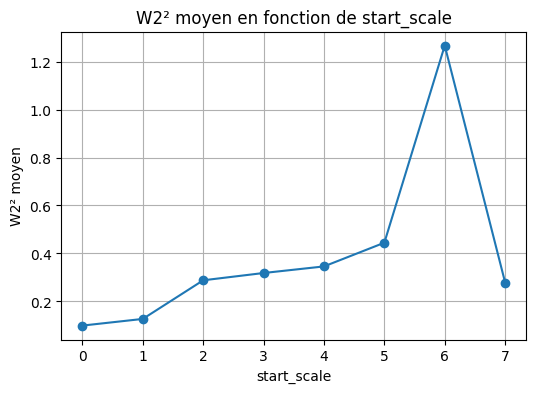

In [168]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(start_scales, w2_avg, marker='o')
plt.xlabel('start_scale')
plt.ylabel('W2² moyen')
plt.title('W2² moyen en fonction de start_scale')
plt.grid(True)
plt.show()

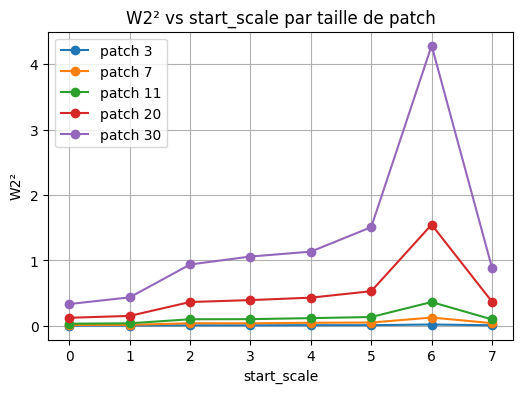

In [169]:
plt.figure(figsize=(6,4))
for ps in patch_sizes:
    plt.plot(start_scales, w2_results[ps], marker='o', label=f'patch {ps}')
plt.xlabel('start_scale')
plt.ylabel('W2²')
plt.title('W2² vs start_scale par taille de patch')
plt.legend()
plt.grid(True)
plt.show()